# Практика классификации изображений 
На примере лиц известных людей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_lfw_people

In [3]:
people = fetch_lfw_people()

In [4]:
people_hd = fetch_lfw_people(min_faces_per_person=15,resize=1)

In [5]:
len(people_hd.target_names)

96

In [6]:
len(people.target_names)

5749

In [7]:
# вычисляем частоту встречаемости каждого ответа
counts = np.bincount(people.target)
dict_people = {}
# печатаем частоты рядом с ответами
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    dict_people[name]=count

In [8]:
# Сортировка словаря по значениям
dict_people = dict(sorted(dict_people.items(), key=lambda x: x[1],reverse=True))
dict_people['Vladimir Putin']


49

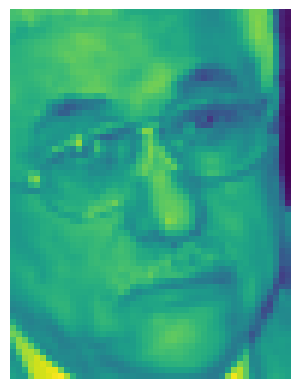

In [9]:
# Вывод изображения
plt.imshow(people.images[1])
plt.axis('off')  # Отключение осей
plt.show()

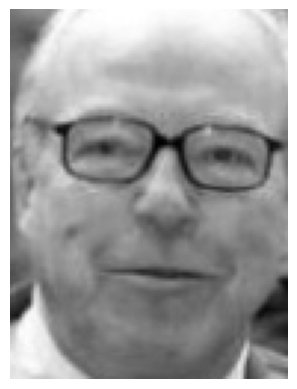

In [10]:
# Вывод изображения
plt.imshow(people_hd.images[1], cmap='gray')
plt.axis('off')  # Отключение осей
plt.show()

# далее функция 

def show_image(image,n=3):
    if n==3:
        plt.imshow(image, cmap='gray')
        plt.axis('off')  
        plt.show()
    if n==1:
        # Преобразование в трехмерный массив
        three_dimensional_array = image.reshape((125,94))
        # Вывод изображения
        plt.imshow(three_dimensional_array, cmap='gray')
        plt.axis('off')
        plt.show()
    

In [11]:
# вычисляем частоту встречаемости каждого ответа
counts = np.bincount(people_hd.target)
dict_people_hd = {}
# печатаем частоты рядом с ответами
for i, (count, name) in enumerate(zip(counts, people_hd.target_names)):
    dict_people_hd[name]=count

In [12]:
all_faces = pd.DataFrame.from_dict(dict_people_hd, orient='index')
all_faces.describe()

,0
count,96.000000
mean,37.447917
std,59.002385
min,15.000000
25%,18.000000
50%,22.500000
75%,33.500000
max,530.000000


In [13]:
# выберем для обучения не более 50 изображений (тк много изображений Буша хехе)
mask = np.zeros(people_hd.target.shape, dtype=np.bool)
for target in np.unique(people_hd.target):
    mask[np.where(people_hd.target == target)[0][:50]] = 1
X_people = people_hd.data[mask]
y_people = people_hd.target[mask]
# для получения большей стабильности масштабируем шкалу оттенков серого так, чтобы значения 
# были в диапазоне от 0 до 1 вместо использования шкалы значений от 0 до 255 
X_people = X_people / 255.


C:\Users\dermi\AppData\Local\Temp\ipykernel_21860\3168408579.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(people_hd.target.shape, dtype=np.bool)


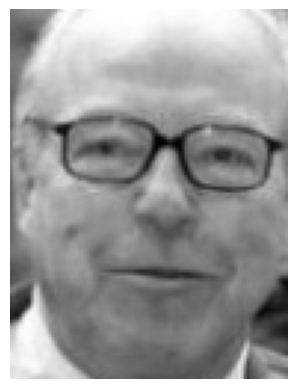

In [14]:
show_image(X_people[1],n=1)
names = people_hd.target_names

## Классификация изображения с помощью KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# разбиваем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=42)

In [16]:
# строим KNeighborsClassifier с одним соседом
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Правильность на тестовом наборе для 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Правильность на тестовом наборе для 1-nn: 0.24


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [17]:
X_train.shape

(1976, 11750)

In [18]:
# уменьшаем размерность для выделения главных признаков
from sklearn.decomposition import PCA
pca = PCA(n_components=80,whiten=True, random_state=42)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
# строим KNN с одним соседом уже для масштабированных признаков (главных компонент)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print(f"Правильность с применением PCA: {knn.score(X_test_pca, y_test):.2f}")

Правильность с применением PCA: 0.30


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Работая с изображениями, мы можем легко визуализировать 
найденные главные компоненты. Вспомним, что компоненты 
соответствуют направлениям в пространстве входных данных.

In [20]:
print("форма pca.components_: {}".format(pca.components_.shape))

форма pca.components_: (80, 11750)


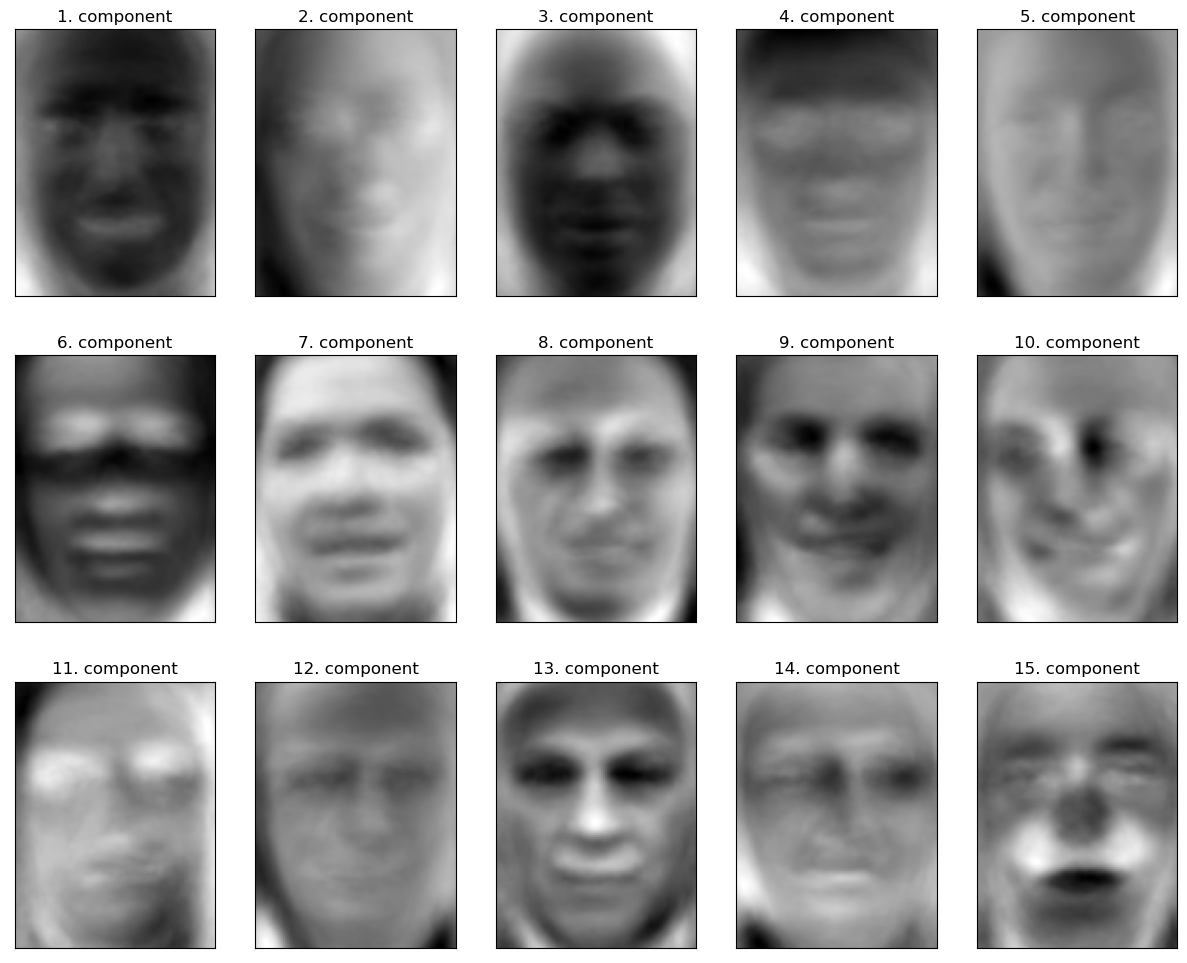

In [21]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
 subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(people_hd.images[0].shape),cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

16


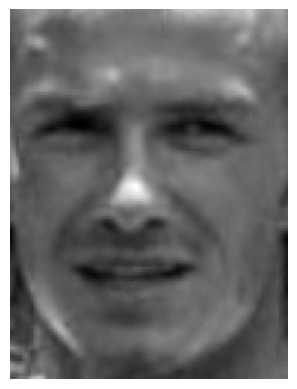

In [22]:
print(y_people[0])
show_image(X_people[0], n=1)

In [23]:
people_df = pd.DataFrame({'Name': names[y_people], 'Target': y_people})
people_df

,Name,Target
0,David Beckham,16
1,Hans Blix,28
2,Donald Rumsfeld,18
3,Tom Daschle,87
4,Alejandro Toledo,1
...,...,...
2630,John Kerry,44
2631,Hamid Karzai,27
2632,George Robertson,20
2633,Vicente Fox,93


In [24]:
# удобный датафрейм с данными

df = pd.DataFrame(people_df['Name'].unique())
df['id'] = people_df['Target'].unique()
image_counts = people_df['Target'].value_counts().reset_index()
image_counts.columns = ['id', 'image_count']
df = pd.merge(df, image_counts, on='id', how='left')
df = df.set_index('id')
df = df.rename(columns={0:'name'})
df = df.sort_values(by='image_count', ascending=False)

In [25]:
people_hd.target_names[94]

'Vladimir Putin'

In [26]:
dict_names = df['name'].to_dict()
dict_names
def find_id(id):
    return dict_names[id]

In [27]:
find_id(94)

'Vladimir Putin'

In [28]:
df_test = pd.DataFrame({'test_id':y_test})
df_test

,test_id
0,82
1,31
2,41
3,74
4,2
...,...
654,45
655,4
656,90
657,52


In [29]:
all_putin_test = df_test[df_test['test_id']==94].index.values
all_putin_test

array([ 37,  39,  77,  87, 113, 117, 131, 268, 269, 338, 573, 653],
      dtype=int64)

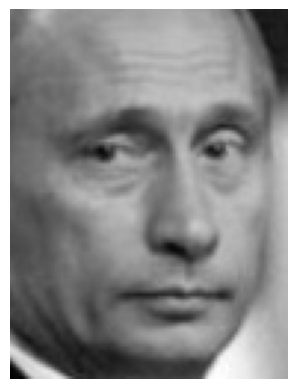

In [30]:
show_image(X_test[87],n=1)

In [31]:
for putin_number in all_putin_test:
    predict = knn.predict([X_test_pca[putin_number]])
    print(find_id(predict[0]),putin_number)  

Vladimir Putin 37
Silvio Berlusconi 39
Roh Moo-hyun 77
Vladimir Putin 87
Bill Simon 113
Vladimir Putin 117
Alvaro Uribe 131
Tony Blair 268
David Beckham 269
Dominique de Villepin 338
Vladimir Putin 573
Jeremy Greenstock 653


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

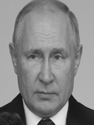

In [32]:
from PIL import Image
import numpy as np

# Загружаем свою картинку
image_path = "putin_new1.png"  # Замените путь на путь к вашей картинке
custom_image = Image.open(image_path)
# Преобразуем изображение в массив NumPy
new_size = (94, 125)
resized_image = custom_image.resize(new_size)
resized_image = resized_image.convert('L')
resized_image

In [33]:
X_new_putin = np.array(resized_image)
X_new_putin = X_new_putin.flatten()

In [34]:
X_new_putin.shape

(11750,)

In [35]:
X_new_putin_pca = pca.transform([X_new_putin])
X_new_putin_pca = X_new_putin_pca[0]

In [36]:
new_predict = knn.predict([X_new_putin_pca])

C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [37]:
find_id(new_predict[0])

'Colin Powell'

## Пименяем NMF

Факторизация неотрицательных матриц – еще один алгоритм
машинного обучения без учителя, цель которого – выделить полезные
характеристики. Он работает так же, как PCA, а также его можно
использовать для уменьшения размерности. 
Процесс разложения данных на неотрицательную взвешенную сумму
особенно полезен для данных, созданных в результате объединения (или 
наложения) нескольких независимых источников, например,
аудиотреков с голосами нескольких людей, музыки с большим 
количеством инструментов. 

#### Поиск паттернов
NMF же, как правило, используется не из-за 
своей способности реконструировать или представлять данные, а скорее
из-за того, что позволяет находить интересные закономерности в данных.

In [38]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

C:\Users\dermi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\dermi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [39]:
# строим KNN с одним соседом уже для масштабированных признаков (главных компонент)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_nmf, y_train)
print(f"Правильность с применением NMF: {knn.score(X_test_nmf, y_test):.2f}")

Правильность с применением NMF: 0.19


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


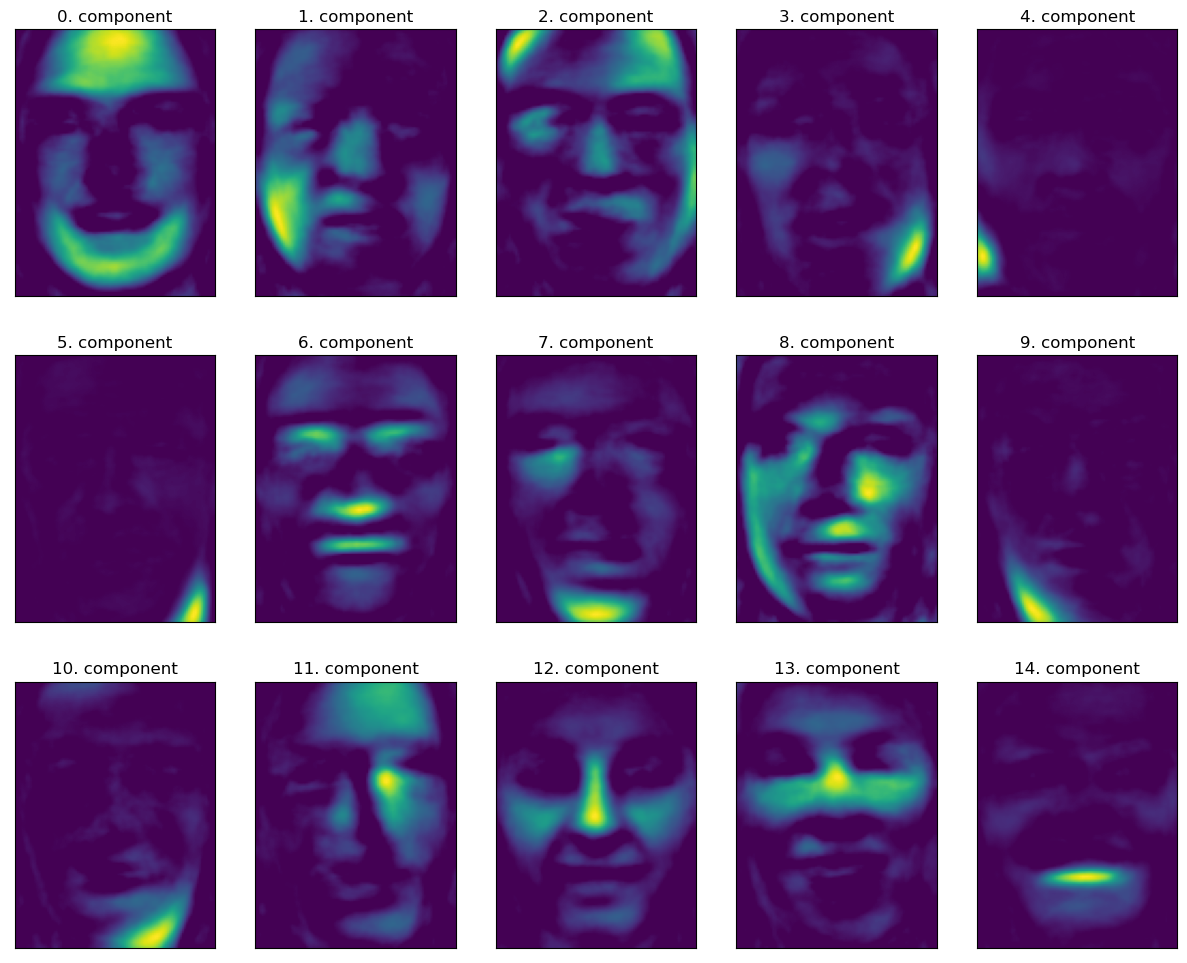

In [40]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(people_hd.images[1].shape))
    ax.set_title("{}. component".format(i))
